In [129]:
import os
import random
from PIL import Image, ImageDraw
from tqdm import tqdm  # 用于生成进度条
import cv2
import matplotlib.pyplot as plt

In [8]:
def remove_white_background(image_path):
    """去除图片的白色背景并返回处理后的图像"""
    image = Image.open(image_path).convert("RGBA")
    pixels = image.load()

    # 遍历每个像素，将接近白色的像素透明化
    width, height = image.size
    for x in range(width):
        for y in range(height):
            r, g, b, a = pixels[x, y]
            # 判断是否为接近白色
            if r > 200 and g > 200 and b > 200:
                pixels[x, y] = (255, 255, 255, 0)  # 设置透明
    return image

def process_directory(input_dir, output_dir):
    """处理文件夹中的所有图片文件"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 获取所有图片文件路径，包含子文件夹
    all_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):  # 只处理图片文件
                all_files.append(os.path.join(root, file))
    
    # 使用tqdm显示进度条
    for input_file_path in tqdm(all_files, desc="Processing Images", unit="file"):
        # 计算输出文件夹路径
        relative_path = os.path.relpath(os.path.dirname(input_file_path), input_dir)
        output_folder = os.path.join(output_dir, relative_path)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # 处理图片并保存
        output_file_path = os.path.join(output_folder, f"{os.path.basename(input_file_path)}.png")
        processed_image = remove_white_background(input_file_path)
        processed_image.save(output_file_path, 'PNG')

# 示例使用
input_directory = r'E:\ipynb\datasets\math_need_to_use'  # 输入文件夹路径
output_directory = r'E:\ipynb\datasets\math_need_process'  # 输出文件夹路径

process_directory(input_directory, output_directory)

Processing Images: 100%|██████████| 69415/69415 [01:16<00:00, 910.02file/s] 


In [5]:
# 定义路径
small_images_dir = r"E:\ipynb\datasets\math_need_process"  # 小图片存放路径
class_mapping_path = r"E:\ipynb\v2_train\class.txt"  # 类别映射文件路径

# 生成类别映射
class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(small_images_dir)))}
with open(class_mapping_path, "w") as mapping_file:
    for class_name, class_id in class_mapping.items():
        mapping_file.write(f"{class_name}\n")

# 创建反转映射表，用于根据索引获取类别名称
reverse_class_mapping = {idx: class_name for class_name, idx in class_mapping.items()}

# 存储每个类别的图片列表
all_categories = []  # 用于存储每个类别的列表
for class_name in sorted(os.listdir(small_images_dir)):  # 遍历文件夹，保证顺序一致
    class_path = os.path.join(small_images_dir, class_name)
    if os.path.isdir(class_path):
        current_category = []  # 当前类别的图片列表
        for filename in os.listdir(class_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                with Image.open(os.path.join(class_path, filename)) as img:
                    # 保存图片和类别编号到当前类别列表
                    current_category.append((img.copy(), class_mapping[class_name]))
        all_categories.append(current_category)  # 将当前类别的列表加入总列表

# 汇总所有类别的图片到一个列表
small_images = [item for category in all_categories for item in category]

# 示例：访问每个类别的图片列表
for i, category in enumerate(all_categories):
    category_name = reverse_class_mapping[i]  # 根据索引获取类别名称
    print(f"Category {i}: {category_name} has {len(category)} images.")


Category 0: + has 5080 images.
Category 1: - has 6000 images.
Category 2: 0 has 5430 images.
Category 3: 1 has 8190 images.
Category 4: 2 has 6010 images.
Category 5: 3 has 6359 images.
Category 6: 4 has 6000 images.
Category 7: 5 has 3545 images.
Category 8: 6 has 3118 images.
Category 9: 7 has 2909 images.
Category 10: 8 has 3068 images.
Category 11: 9 has 3737 images.
Category 12: = has 5160 images.
Category 13: [ has 778 images.
Category 14: ] has 780 images.
Category 15: times has 3251 images.


In [90]:
# 定义路径
output_images_dir = r"E:\ipynb\v2_train"  # 生成的图片存放路径
output_labels_dir = r"E:\ipynb\v2_train"  # 标签文件存放路径

# 创建输出目录
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# 定义背景图片大小
background_size = (512 + random.randint(-200, 200), 512 + random.randint(-200, 200))

# 定义随机点生成函数
def generate_random_points(num_points, min_distance, max_x, max_y):
    """生成尽量均匀分布且不重叠的随机点"""
    points = []
    attempts = 0
    while len(points) < num_points and attempts < 10000:
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)
        # 检查当前点是否与已有点的距离小于最小距离
        if all(((x - px) ** 2 + (y - py) ** 2) ** 0.5 >= min_distance for px, py in points):
            points.append((x, y))
        attempts += 1
    return points

# 生成 10000 张图片
for img_idx in tqdm(range(60000), desc="Generating Images"):  # 使用 tqdm 添加进度条
    # 创建透明背景
    background = Image.new("RGBA", background_size, (255, 255, 255, 0))  # 完全透明背景
    draw = ImageDraw.Draw(background)

    annotations = []  # 用于存储标注内容

    # 随机生成小图片放置点
    num_objects = random.randint(10, 20)  # 每张图片随机放置 10-20 个小图片
    points = generate_random_points(
        num_objects,
        min_distance=50,  # 最小间距，避免重叠
        max_x=background_size[0] - 1,
        max_y=background_size[1] - 1,
    )

    # 将每个点作为小图片的左上角
    for (x_min, y_min) in points:
        small_img, label_id = random.choice(small_images)  # 随机选取小图片
        scale = random.uniform(0.5, 1.5)  # 随机缩放比例
        resized_img = small_img.resize((int(45 * scale), int(45 * scale)))

        # 检查是否超出背景边界
        if x_min + resized_img.size[0] > background_size[0] or y_min + resized_img.size[1] > background_size[1]:
            continue  # 超出边界则跳过

        # 计算边界
        x_max = x_min + resized_img.size[0]
        y_max = y_min + resized_img.size[1]

        # 粘贴小图片到背景
        background.paste(resized_img, (x_min, y_min), resized_img.convert("RGBA").split()[3])  # 保持透明区域不覆盖

        # 归一化坐标
        x_center = round((x_min + x_max) / 2 / background_size[0], 6)
        y_center = round((y_min + y_max) / 2 / background_size[1], 6)
        width = round((x_max - x_min) / background_size[0], 6)
        height = round((y_max - y_min) / background_size[1], 6)

        # 添加标注（使用类别数字和归一化后的坐标）
        annotations.append(f"{label_id} {x_center} {y_center} {width} {height}")

    # 添加随机黑色噪点
    num_noise_points = random.randint(25, 125)  # 随机噪点数量
    for _ in range(num_noise_points):
        noise_x = random.randint(0, background_size[0] - 1)
        noise_y = random.randint(0, background_size[1] - 1)
        draw.point((noise_x, noise_y), fill="black")  # 在背景上绘制黑点

    # 将透明背景填充为白色
    white_background = Image.new("RGBA", background.size, (255, 255, 255, 255))  # 创建一个白色背景
    white_background.paste(background, (0, 0), background.convert("RGBA").split()[3])  # 使用Alpha通道粘贴原图

    # 转换为RGB模式，去掉Alpha通道
    final_image = white_background.convert("RGB")  # 转换为RGB模式，去除Alpha通道

    # 保存图片
    image_path = os.path.join(output_images_dir, f"alpha_{img_idx}.png")
    final_image.save(image_path)

    # 保存标注
    label_path = os.path.join(output_labels_dir, f"alpha_{img_idx}.txt")
    with open(label_path, "w") as label_file:
        label_file.write("\n".join(annotations))

Generating Images: 100%|██████████| 60000/60000 [11:55<00:00, 83.85it/s] 


In [91]:
number_images = [item for category in all_categories[2:12] for item in category[2:12]]
minus_images = [item for item in all_categories[1]]

# 定义路径
output_images_dir = r"E:\ipynb\v2_train"  # 生成的图片存放路径
output_labels_dir = r"E:\ipynb\v2_train"  # 标签文件存放路径

# 创建输出目录
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# 定义背景图片大小
background_size = (200 + random.randint(-50, 50), 150 + random.randint(-50, 50))

# 定义生成水平排列的函数
def generate_horizontal_sequence(num_items, background_width, item_width_range):
    """生成水平排列的点位置"""
    start_x = random.randint(0, background_width // 5)  # 随机起点
    y_min = random.randint(20, background_size[1] - 75)  # 随机一个固定水平线
    positions = []
    for i in range(num_items):
        width = random.randint(*item_width_range)  # 随机宽度
        positions.append((start_x, y_min))
        start_x += width + random.randint(5, 15)  # 水平间隔
    return positions

# 生成 10000 张图片
for img_idx in tqdm(range(60000), desc="Generating Images"):  # 使用 tqdm 添加进度条
    # 创建透明背景
    background = Image.new("RGBA", background_size, (255, 255, 255, 0))  # 完全透明背景
    draw = ImageDraw.Draw(background)

    annotations = []  # 用于存储标注内容

    # 随机生成1-3个项目数字
    num_objects = random.randint(1, 3)
    positions = generate_horizontal_sequence(
        num_objects, 
        background_width=background_size[0], 
        item_width_range=(30, 50)
    )

    # 将每个图片放置到水平线上
    for idx, (x_min, y_min) in enumerate(positions):
        if idx == 0 and random.random() < 0.5 and num_objects > 1:
            small_img, label_id = random.choice(minus_images)
        else:
            small_img, label_id = random.choice(number_images)  # 随机选取数字或符号图片
        scale = random.uniform(0.8, 1.2)  # 随机缩放比例
        resized_img = small_img.resize((int(small_img.size[0] * scale), int(small_img.size[1] * scale)))

        # 检查是否超出背景边界
        if x_min + resized_img.size[0] > background_size[0] or y_min + resized_img.size[1] > background_size[1]:
            continue  # 超出边界则跳过

        # 计算边界
        x_max = x_min + resized_img.size[0]
        y_max = y_min + resized_img.size[1]

        # 粘贴小图片到背景
        background.paste(resized_img, (x_min, y_min), resized_img.convert("RGBA").split()[3])  # 保持透明区域不覆盖

        # 归一化坐标
        x_center = round((x_min + x_max) / 2 / background_size[0], 6)
        y_center = round((y_min + y_max) / 2 / background_size[1], 6)
        width = round((x_max - x_min) / background_size[0], 6)
        height = round((y_max - y_min) / background_size[1], 6)

        # 添加标注（使用类别数字和归一化后的坐标）
        annotations.append(f"{label_id} {x_center} {y_center} {width} {height}")

    # 添加随机黑色噪点
    num_noise_points = random.randint(2,25)  # 随机噪点数量
    for _ in range(num_noise_points):
        noise_x = random.randint(0, background_size[0] - 1)
        noise_y = random.randint(0, background_size[1] - 1)
        draw.point((noise_x, noise_y), fill="black")  # 在背景上绘制黑点

    # 将透明背景填充为白色
    white_background = Image.new("RGBA", background.size, (255, 255, 255, 255))  # 创建一个白色背景
    white_background.paste(background, (0, 0), background.convert("RGBA").split()[3])  # 使用Alpha通道粘贴原图

    # 转换为RGB模式，去掉Alpha通道
    final_image = white_background.convert("RGB")  # 转换为RGB模式，去除Alpha通道

    # 保存图片
    image_path = os.path.join(output_images_dir, f"horizontal_{img_idx}.png")
    final_image.save(image_path)

    # 保存标注
    label_path = os.path.join(output_labels_dir, f"horizontal_{img_idx}.txt")
    with open(label_path, "w") as label_file:
        label_file.write("\n".join(annotations))


Generating Images: 100%|██████████| 60000/60000 [01:59<00:00, 500.01it/s]


In [378]:
# 定义括号和数字图片
bracket_left_images = [item for item in all_categories[13]]  # 左括号 "["
bracket_right_images = [item for item in all_categories[14]]  # 右括号 "]"
minus_images = [item for item in all_categories[1]]
number_images = [item for category in all_categories[2:12] for item in category]

# 定义路径
output_images_dir = r"E:\ipynb\v3_train"  # 生成的图片存放路径
output_labels_dir = r"E:\ipynb\v3_train"  # 标签文件存放路径

# 创建输出目录
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# 生成图片
for img_idx in tqdm(range(100000), desc="Generating Images"):
    # 随机生成矩阵行列数
    num_rows = random.randint(1, 3)  # 随机1-3行
    num_cols = random.randint(1, 3)  # 随机1-3列
    if num_cols == num_rows == 1:
        if random.random() < 0.5:
            num_cols += 1
        else:
            num_rows += 1

    # 定义单元格大小和间隔
    cell_width = 200  # 每个单元格的宽度基准
    cell_height = 150  # 每个单元格的高度基准
    horizontal_gap = 50  # 横向间隔基准
    vertical_gap = 20  # 纵向间隔基准
    spacing_factor = 0.8  # 间隔缩小比例

    # 动态计算背景大小
    background_width = (
        cell_width * num_cols + horizontal_gap * (num_cols - 1) +
        2 * (200)  # 假设括号宽度的基准为200，左右各增加边距
    )
    background_height = (
        cell_height * num_rows + vertical_gap * (num_rows - 1) +
        100  # 增加上下边距
    )
    background_size = (background_width, background_height)

    # 创建透明背景
    background = Image.new("RGBA", background_size, (255, 255, 255, 0))  # 完全透明背景
    draw = ImageDraw.Draw(background)
    annotations = []  # 存储标注

    # 动态调整括号的拉伸比例
    vertical_stretch_left = max(2, 3 - (num_rows - 1) * 0.3)  # 行数越多，拉伸比例越小
    vertical_stretch_right = vertical_stretch_left

    # 加载左括号
    left_bracket_img, left_label_id = random.choice(bracket_left_images)
    scale_left = background_size[1] / left_bracket_img.size[1] / 3
    left_bracket_resized = left_bracket_img.resize(
        (int(left_bracket_img.size[0] * scale_left),
         int(left_bracket_img.size[1] * scale_left * vertical_stretch_left))
    )
    left_y_offset = (background_size[1] - left_bracket_resized.size[1]) // 2
    background.paste(left_bracket_resized, (0, left_y_offset), left_bracket_resized.convert("RGBA"))

    # 左括号标注
    left_width = left_bracket_resized.size[0] / background_size[0]
    left_height = left_bracket_resized.size[1] / background_size[1]
    left_center_x = (left_bracket_resized.size[0] / 2) / background_size[0]
    left_center_y = (left_y_offset + left_bracket_resized.size[1] / 2) / background_size[1]
    annotations.append(f"{left_label_id} {left_center_x:.6f} {left_center_y:.6f} {left_width:.6f} {left_height:.6f}")

    # 加载右括号
    right_bracket_img, right_label_id = random.choice(bracket_right_images)
    scale_right = background_size[1] / right_bracket_img.size[1] / 3
    right_bracket_resized = right_bracket_img.resize(
        (int(right_bracket_img.size[0] * scale_right),
         int(right_bracket_img.size[1] * scale_right * vertical_stretch_right))
    )
    right_x = background_size[0] - right_bracket_resized.size[0]
    right_y_offset = (background_size[1] - right_bracket_resized.size[1]) // 2
    background.paste(right_bracket_resized, (right_x, right_y_offset), right_bracket_resized.convert("RGBA"))

    # 右括号标注
    right_width = right_bracket_resized.size[0] / background_size[0]
    right_height = right_bracket_resized.size[1] / background_size[1]
    right_center_x = (right_x + right_bracket_resized.size[0] / 2) / background_size[0]
    right_center_y = (right_y_offset + right_bracket_resized.size[1] / 2) / background_size[1]
    annotations.append(f"{right_label_id} {right_center_x:.6f} {right_center_y:.6f} {right_width:.6f} {right_height:.6f}")

    # 生成矩阵内容
    for row in range(num_rows):
        for col in range(num_cols):
            # 计算单元格的最小坐标
            x_min = left_bracket_resized.size[0] + col * (cell_width + horizontal_gap) + cell_width // 4
            y_min = row * (cell_height + vertical_gap) + cell_height // 2
    
            # 随机选取数字
            num_items = random.randint(1, 3)  # 每格随机生成1-3个数字
            total_width = 0  # 计算总宽度用于居中
            images_to_paste = []
            labels_to_append = []  # 用来保存标签
    
            # 计算总宽度
            for item_idx in range(num_items):
                if item_idx == 0 and random.random() < 0.5 and num_items > 1:
                    small_img, label_id = random.choice(minus_images)
                else:
                    small_img, label_id = random.choice(number_images)
                scale = random.uniform(1.5, 2)
                resized_img = small_img.resize(
                    (int(small_img.size[0] * scale), int(small_img.size[1] * scale))
                )
                total_width += resized_img.size[0]  # 累加每个数字的宽度
                images_to_paste.append(resized_img)
                labels_to_append.append(label_id)  # 保存标签
    
            # 计算每个数字之间的间隔，使得它们居中
            total_gap = (cell_width - total_width) / (num_items + 1)
    
            # 粘贴数字并计算每个数字的标注
            for item_idx, (resized_img, label_id) in enumerate(zip(images_to_paste, labels_to_append)):
                # 计算数字的位置
                x_center = (x_min + total_gap * (item_idx + 1) + (item_idx + 0.5) * resized_img.size[0]) / background_size[0]
                y_center = (y_min + resized_img.size[1] / 2) / background_size[1]
                width = resized_img.size[0] / background_size[0]
                height = resized_img.size[1] / background_size[1]
    
                # 粘贴数字
                background.paste(
                    resized_img,
                    (x_min + int((item_idx + 1) * total_gap) + sum(resized_img.size[0] for resized_img in images_to_paste[:item_idx]), y_min),
                    resized_img.convert("RGBA")
                )
    
                # 添加标注
                annotations.append(f"{label_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # 添加随机黑色噪点
    num_noise_points = random.randint(25, 50)  # 随机噪点数量
    for _ in range(num_noise_points):
        # 随机生成噪点位置
        noise_x = random.randint(0, background_size[0] - 1)
        noise_y = random.randint(0, background_size[1] - 1)
        
        # 随机生成噪点的大小（可以调整范围）
        noise_size = random.randint(1, 2)  # 随机生成噪点的最大半径大小
    
        # 设置渐变的颜色，中心为黑色，外围逐渐变透明
        for i in range(noise_size , 0, -1):  # 从大到小逐步绘制圆
            alpha = int(255 * ((noise_size - i) / noise_size))  # 渐变透明度，越大越不透明
            color = (0, 0, 0, alpha)  # 黑色，透明度逐渐减小
    
            # 在噪点位置绘制一个具有渐变透明度的黑色圆形
            draw.ellipse(
                (noise_x - i, noise_y - i, noise_x + i, noise_y + i),
                fill=color
            )
    
    
    # 填充为白色背景
    white_background = Image.new("RGBA", background.size, (255, 255, 255, 255))
    white_background.paste(background, (0, 0), background.convert("RGBA").split()[3])
    final_image = white_background.convert("RGB")

    # 保存图片
    image_path = os.path.join(output_images_dir, f"matrix_{img_idx}.png")
    final_image.save(image_path)

    # 保存标注
    label_path = os.path.join(output_labels_dir, f"matrix_{img_idx}.txt")
    with open(label_path, "w") as label_file:
        label_file.write("\n".join(annotations))



Generating Images: 100%|██████████| 100000/100000 [24:42<00:00, 67.47it/s]


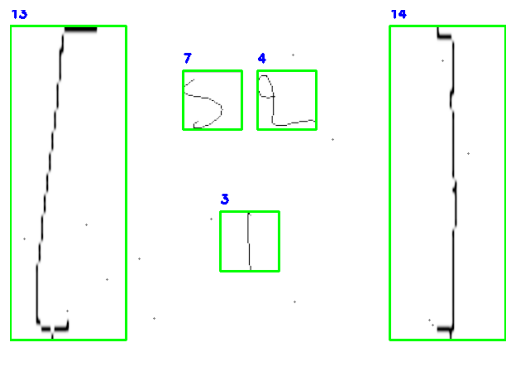

In [376]:
def draw_boxes_on_image(image_path, label_file):
    # 读取图片
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # 打开并读取label文件
    with open(label_file, 'r') as f:
        lines = f.readlines()

    # 遍历每一行，提取信息并画框
    for line in lines:
        # 解析label文件中的一行
        class_name, center_x, center_y, width, height = line.strip().split()
        center_x, center_y, width, height = float(center_x), float(center_y), float(width), float(height)
        
        # 将归一化的坐标转换为像素坐标
        x1 = int((center_x - width / 2) * w)
        y1 = int((center_y - height / 2) * h)
        x2 = int((center_x + width / 2) * w)
        y2 = int((center_y + height / 2) * h)

        # 在图片上画出矩形框
        color = (0, 255, 0)  # 绿色
        thickness = 2
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
        
        # 在框上标注类别
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, class_name, (x1, y1 - 10), font, 0.5, (255, 0, 0), 2)

    # 转换为RGB格式以正确显示
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 使用matplotlib显示图片
    plt.imshow(image_rgb)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

# 输入图片路径和标注文件路径
image_path = r'E:\ipynb\v3_train\matrix_0.png'
label_file = r'E:\ipynb\v3_train\matrix_0.txt'

# 调用函数
draw_boxes_on_image(image_path, label_file)
